In [1]:
import pandas as pd
import numpy as np
# import seaborn as sns
from math import sin, cos, pi
import matplotlib.pyplot as plt
# from google.colab import files

import torch
from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS
from sklearn.model_selection import train_test_split

from qiskit import QuantumCircuit
# from qiskit_machine_learning.optimizers import COBYLA

# from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# from qiskit.primitives import StatevectorEstimator
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_aer import AerSimulator
from scipy.optimize import minimize
from qiskit.circuit.library import PauliEvolutionGate
from sklearn.metrics import log_loss
from scipy.special import softmax

In [4]:
import importlib
packages = ['numpy', 'pandas', 'scipy', 'qiskit', 'torch', 'matplotlib', 'sklearn','seaborn']

for pkg in packages:
    try:
        mod = importlib.import_module(pkg)
        print(f"{pkg}: {getattr(mod, '__version__', 'version not available')}")
    except ImportError:
        print(f"{pkg}: not installed")

numpy: 2.2.5
pandas: 2.2.3
scipy: 1.15.3
qiskit: 1.4.2
torch: 2.7.0+cpu
matplotlib: 3.10.3
sklearn: 1.6.1
seaborn: 0.13.2


In [2]:
df = pd.read_csv('susy_1000.csv')

In [3]:
df.head()

,lepton 1 pT,lepton 2 pT,missing energy magnitude,SUSY
0,1.742754,1.423210,1.831006,1.0
1,0.766916,0.827923,2.636657,1.0
2,0.658630,0.843965,0.103182,1.0
3,0.613593,0.875340,0.387255,0.0
4,0.680474,1.116256,0.735401,0.0


In [4]:
def min_max_scaling(x,axis=None):
  """Normalized to [-1, 1]"""
  min = x.min(axis=axis)
  max = x.max(axis=axis)
  result = (x-min)/(max-min)
  result = (2.0*result)-1.0
  return result

In [103]:
selected_features = ['lep_met_sum', 'mT', 'met','Label']
three_df = df[selected_features]

In [104]:
import pandas as pd
from sklearn.utils import resample

# Assuming df is your dataframe and 'Label' is the column with 0/1 values
zero_count = len(three_df[three_df['Label'] == 0])
one_count = len(three_df[three_df['Label'] == 1])

# Determine your desired counts
desired_zero_ratio = 0.35  # 30% zeros
desired_one_ratio = 0.65   # 70% ones
total_samples = 15000      # Total samples in new dataset

zero_samples = int(total_samples * desired_zero_ratio)
one_samples = int(total_samples * desired_one_ratio)

# Downsample the majority class
df_zero = three_df[three_df['Label'] == 0].sample(n=zero_samples, random_state=81)
df_one = three_df[three_df['Label'] == 1].sample(n=one_samples, random_state=81)

# Combine and shuffle
balanced_df = pd.concat([df_zero, df_one]).sample(frac=1, random_state=81).reset_index(drop=True)

In [105]:
balanced_df['Label'].value_counts()


Label
1    9750
0    5250
Name: count, dtype: int64

In [5]:
raw_X = df.drop(columns=['SUSY'])
# raw_X = raw_X.astype(np.complex128)
features = min_max_scaling(raw_X.values)
# features = raw_X.values
Y = df['SUSY']
labels = Y.values

In [6]:
# Function to create the Ising Hamiltonian with random coefficients
def create_ising_hamiltonian(nqubit):
    """Create an Ising Hamiltonian with random magnetic fields and couplings."""
    pauli_terms = []
    coefficients = []

    # Random magnetic fields (X terms)
    for i in range(nqubit):
        Jx = -1.0 + 2.0 * np.random.rand()  # Random coefficient in [-1, 1]
        pauli_terms.append(f"I" * i + "X" + "I" * (nqubit - i - 1))
        coefficients.append(Jx)

    # Random couplings (ZZ terms)
    for i in range(nqubit):
        for j in range(i + 1, nqubit):
            J_ij = -1.0 + 2.0 * np.random.rand()  # Random coefficient in [-1, 1]
            pauli_terms.append(f"I" * i + "Z" + "I" * (j - i - 1) + "Z" + "I" * (nqubit - j - 1))
            coefficients.append(J_ij)

    # Create the Hamiltonian as a SparsePauliOp
    hamiltonian = SparsePauliOp(pauli_terms, coefficients)
    return hamiltonian

# Function to construct the U() gate
def construct_U_gate(nqubit, time_step=0.77):
    """Construct the U() gate using time-evolution and parameterized RX, RZ, RX gates."""
    # Create the Ising Hamiltonian
    hamiltonian = create_ising_hamiltonian(nqubit)

    # Create the time-evolution gate
    evolution_gate = PauliEvolutionGate(hamiltonian, time=time_step)

    # Create a quantum circuit
    qc = QuantumCircuit(nqubit)
    
    # Add the time-evolution gate
    qc.append(evolution_gate, range(nqubit))
    return qc

In [7]:
theta1 = Parameter("a")
theta2 = Parameter("b")
theta3 = Parameter("c")
theta4 = Parameter("d")
theta5 = Parameter("e")
theta6 = Parameter("f")
theta7 = Parameter("g")
theta8 = Parameter("h")
theta9 = Parameter("i")



def var_circ_qcl():
  qc = QuantumCircuit(3)
  # n = qc.num_qubits
  qc = qc.compose(construct_U_gate(3))
  qc.barrier()
  qc.rx(theta1,0)
  qc.rz(theta4,0)
  qc.rx(theta2,1)
  qc.rz(theta5,1)
  qc.rx(theta3,2)
  qc.rz(theta6,2)
  qc.rx(theta7,0)
  qc.rx(theta8,1)
  qc.rx(theta9,2)

  return qc
ansatz = var_circ_qcl()

In [8]:
input1 = Parameter("u")
input2 = Parameter("v")
input3 = Parameter("x")
def qnn_encoding_qcl():

  qc = QuantumCircuit(3)
  n = qc.num_qubits
  # Encoding circuit
  # for i in range(n):
  #   qc.ry(np.arcsin(inputs[i]),i)
  #   qc.rz(np.arccos(inputs[i]**2),i)
  #   qc.h(i)
  qc.ry(np.arcsin(input1),0)
  qc.ry(np.arcsin(input2),1)
  qc.ry(np.arcsin(input3),2)
  qc.rz(np.arccos(input1**2),0)
  qc.rz(np.arccos(input2**2),1)
  qc.rz(np.arccos(input3**2),2)
  qc.barrier()
  # qc.rz(input4,3)
  # qc.rz(input5,4)
  return qc

In [9]:
def circ_qnn_qcl():
  qc = QuantumCircuit(3)
  mapping = qnn_encoding_qcl()
  # mapping = prep
  ansatz = var_circ_qcl()
  # ansatz_ = ansatz_qnn
  encoder = qc.compose(mapping)
  classifier = encoder.compose(ansatz)
  return classifier

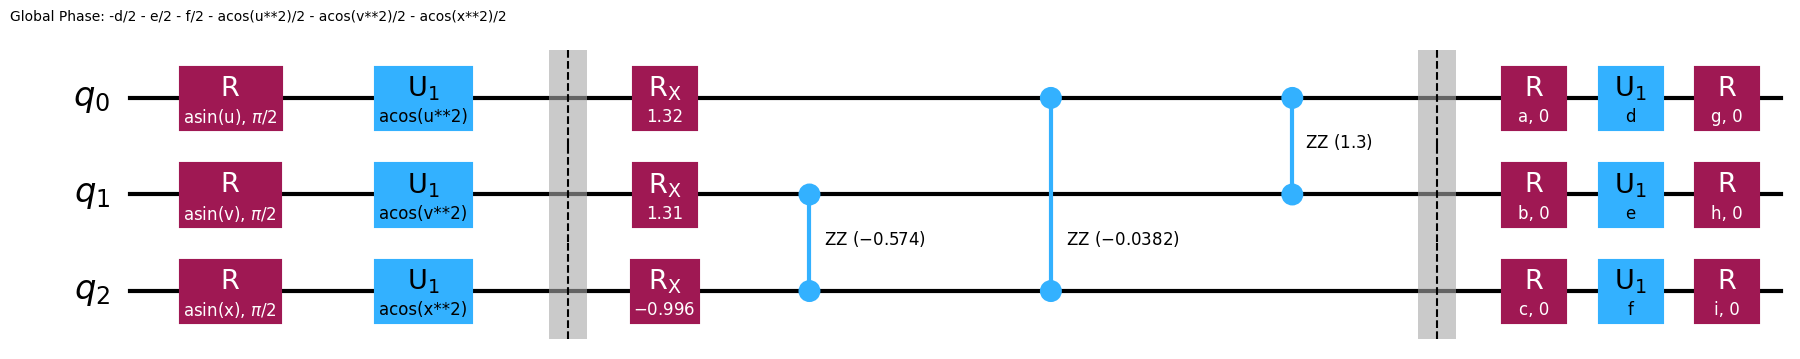

In [111]:
qc = circ_qnn_qcl()
qc.decompose().draw('mpl', scale=1.5, filename='qcircuit.png')

In [10]:
from sklearn.model_selection import train_test_split

# Assuming you have features X and labels y
X_train, X_test, y_train, y_test = train_test_split(
    features,
    labels,
    test_size=0.25,  # 20% for testing (adjust as needed)
    random_state=42,  # for reproducibility
    stratify=labels  # preserves class distribution (recommended for classification)
)

In [11]:
qnn_qcl = EstimatorQNN(
    circuit=circ_qnn_qcl(), input_params=qnn_encoding_qcl().parameters, weight_params=var_circ_qcl().parameters)

C:\Users\Aryan\AppData\Local\Temp\ipykernel_11204\2971372496.py:1: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn_qcl = EstimatorQNN(


In [12]:
initial_weights = (2 * algorithm_globals.random.random(9) - 1)

model_qcl = TorchConnector(qnn_qcl, initial_weights=initial_weights)
# print("Initial weights: ", initial_weights)

In [13]:
optimizer = LBFGS(model_qcl.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model_qcl.train()

TorchConnector()

In [14]:
labels_=Tensor(y_train).reshape(len(y_train), 1)
def closure():
    optimizer.zero_grad()  # Initialize/clear gradients
    loss = f_loss(model_qcl(Tensor(X_train)), labels_)  # Evaluate loss function
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss
    # Run optimizer step4
optimizer.step(closure)

420.709716796875
243.11428833007812
226.213623046875
208.67889404296875
194.79905700683594
176.45184326171875
166.96084594726562
558.906005859375
163.0224151611328
160.62303161621094
156.77305603027344
153.1739501953125
147.334228515625
142.73548889160156
140.6105194091797
139.2633819580078
136.50918579101562
135.9487762451172
135.4210662841797
135.19589233398438


tensor(420.7097, grad_fn=<MseLossBackward0>)

In [15]:
model_qcl.eval()
y_predict_qcl = []
y_pred_prob_qcl = []
threshold = 0.5

for x, y_target in zip(X_test, y_test):
    # Forward pass: get model output
    output = model_qcl(Tensor(x))
    mapped_output = output.detach().numpy()[0]

    # print(output)
    # Store the predicted probability
    y_pred_prob_qcl.append(mapped_output)

    # Convert the output probability to a binary prediction using the threshold
    binary_prediction = 1 if output.detach().numpy()[0] >= threshold else 0
    y_predict_qcl.append(binary_prediction)

# Calculate accuracy
accuracy_qcl = sum(np.array(y_predict_qcl) == np.array(y_test)) / len(y_test)
print("Accuracy:", accuracy_qcl)

Accuracy: 0.764


In [16]:
raw_outputs = []
mapped_outputs = []
true_labels = []

for x, y_target in zip(X_test, y_test):
    output = model_qcl(Tensor(x))
    raw = output.detach().numpy()[0]
    mapped = 1- raw

    raw_outputs.append(raw)
    mapped_outputs.append(mapped)
    true_labels.append(y_target)


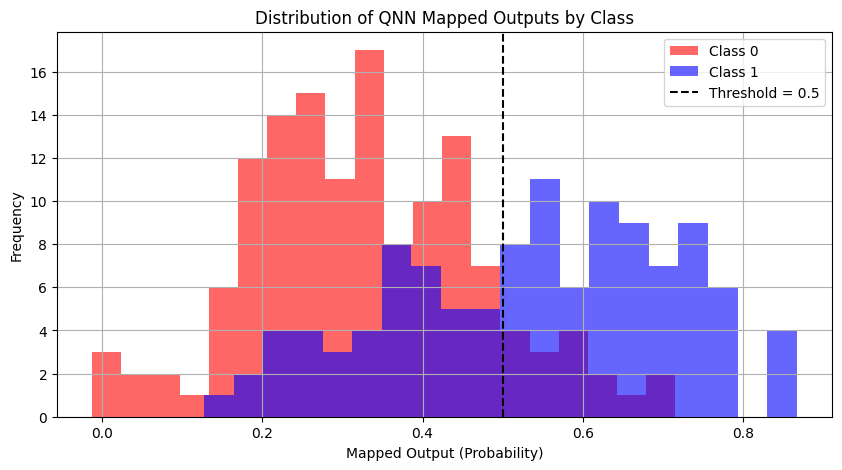

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy arrays
raw_outputs = np.array(raw_outputs)
mapped_outputs = np.array(mapped_outputs)
true_labels = np.array(true_labels)

# Plot histogram for mapped outputs by class
plt.figure(figsize=(10, 5))
plt.hist(raw_outputs[true_labels == 0], bins=20, alpha=0.6, label='Class 0', color='red')
plt.hist(raw_outputs[true_labels == 1], bins=20, alpha=0.6, label='Class 1', color='blue')
plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold = 0.5')
plt.title("Distribution of QNN Mapped Outputs by Class")
plt.xlabel("Mapped Output (Probability)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


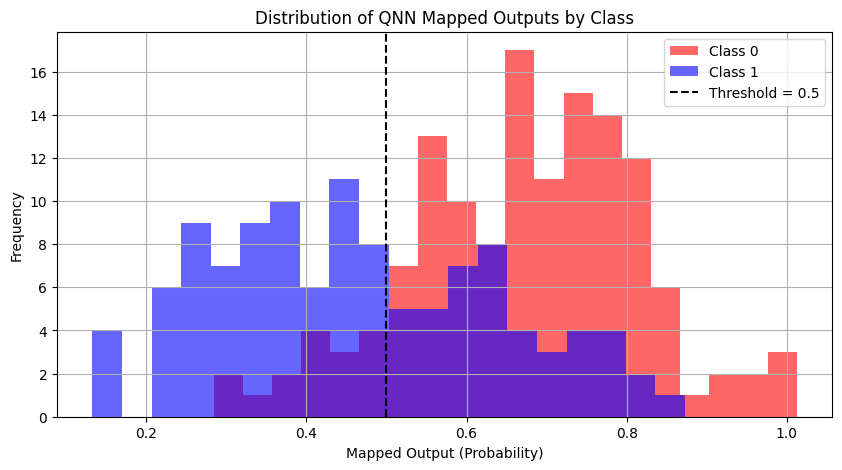

In [19]:
plt.figure(figsize=(10, 5))
plt.hist(mapped_outputs[true_labels == 0], bins=20, alpha=0.6, label='Class 0', color='red')
plt.hist(mapped_outputs[true_labels == 1], bins=20, alpha=0.6, label='Class 1', color='blue')
plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold = 0.5')
plt.title("Distribution of QNN Mapped Outputs by Class")
plt.xlabel("Mapped Output (Probability)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Convert to numpy arrays if not already
y_true = np.array(y_test)
y_pred = np.array(y_predict_qcl)

# Compute metrics treating class 0 as the positive class
precision = precision_score(y_true, y_pred, pos_label=0)
recall = recall_score(y_true, y_pred, pos_label=0)
f1 = f1_score(y_true, y_pred, pos_label=0)

print(f"Precision (class 0): {precision:.4f}")
print(f"Recall (class 0):    {recall:.4f}")
print(f"F1 Score (class 0):  {f1:.4f}")



Precision (class 0): 0.7378
Recall (class 0):    0.8832
F1 Score (class 0):  0.8040


In [133]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Convert to numpy arrays if not already
y_true = np.array(y_test)
y_pred = np.array(y_predict_qcl)

# Specify that class '0' is the positive label
precision = precision_score(y_true, y_pred, pos_label=0)
recall = recall_score(y_true, y_pred, pos_label=0)
f1 = f1_score(y_true, y_pred, pos_label=0)

# Optional: print confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Print results
print(f"Precision (for class 0): {precision:.4f}")
print(f"Recall (for class 0):    {recall:.4f}")
print(f"F1 Score (for class 0):  {f1:.4f}")
print("\nConfusion Matrix:")
print(cm)


Precision (for class 0): 0.9810
Recall (for class 0):    0.9025
F1 Score (for class 0):  0.9401

Confusion Matrix:
[[1185  128]
 [  23 2414]]


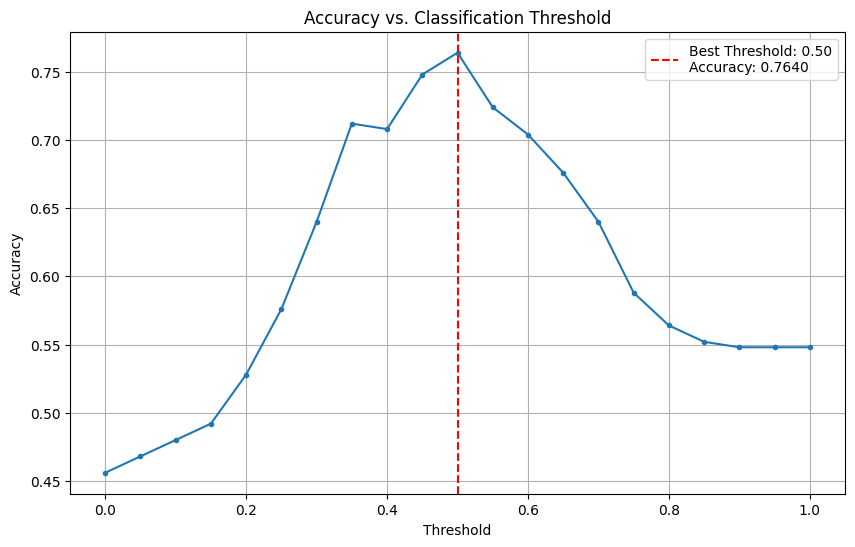

Maximum accuracy of 0.7640 achieved at threshold 0.50


In [20]:
import numpy as np
import matplotlib.pyplot as plt

model_qcl.eval()
y_pred_probs = []  # Store all prediction probabilities first

# First, get all prediction probabilities
for x, y_target in zip(X_test, y_test):
    output = model_qcl(Tensor(x))
    y_pred_probs.append(output.detach().numpy()[0])

y_pred_probs = np.array(y_pred_probs)
y_test = np.array(y_test)

# Define a range of thresholds to test
thresholds = np.linspace(0, 1, 21)  # 0.00, 0.01, 0.02, ..., 1.00
accuracies = []

for threshold in thresholds:
    # Convert probabilities to binary predictions using current threshold
    y_predict_qcl = (y_pred_probs >= threshold).astype(int)

    # Calculate accuracy
    accuracy = np.mean(y_predict_qcl == y_test)
    accuracies.append(accuracy)

# Find the threshold that gives maximum accuracy
max_acc = max(accuracies)
best_threshold = thresholds[accuracies.index(max_acc)]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, marker='o', markersize=3)
plt.title('Accuracy vs. Classification Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.grid(True)

# Mark the best threshold
plt.axvline(x=best_threshold, color='r', linestyle='--',
            label=f'Best Threshold: {best_threshold:.2f}\nAccuracy: {max_acc:.4f}')
plt.legend()

plt.show()

print(f"Maximum accuracy of {max_acc:.4f} achieved at threshold {best_threshold:.2f}")

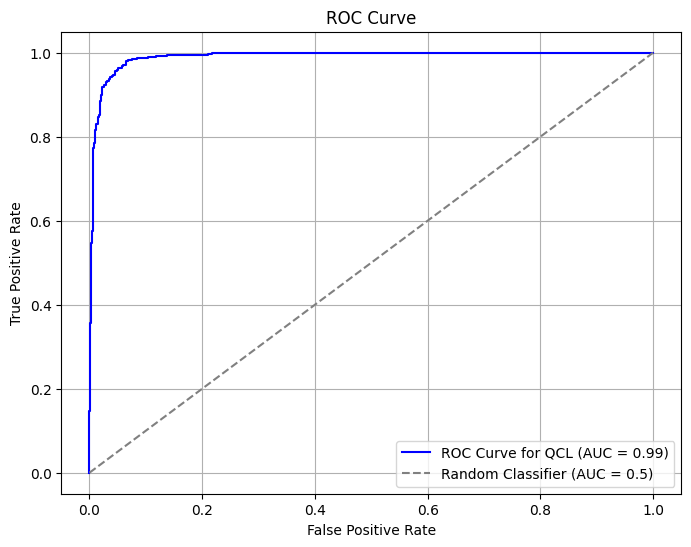

AUC Score: 0.9901144615384615


In [63]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert to NumPy array
y_pred_prob_qcl = np.array(y_pred_prob_qcl)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_qcl)

# print(thresholds)
roc_auc_1 = auc(fpr, tpr)

# # Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve for QCL (AUC = {roc_auc_1:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print the AUC score
print("AUC Score:", roc_auc_1)


In [135]:
def calculate_tpr_fpr(y_true, y_predict):
    """
    Calculate True Positive Rate (TPR) and False Positive Rate (FPR) for a fixed threshold.

    Args:
        y_true (list): List of true binary labels (0 or 1).
        y_predict (list): List of predicted binary labels (0 or 1).

    Returns:
        TPR (float): True Positive Rate.
        FPR (float): False Positive Rate.
    """
    # Calculate True Positives (TP), False Positives (FP), True Negatives (TN), False Negatives (FN)
    TP = sum((true == 1 and pred == 1) for true, pred in zip(y_true, y_predict))
    FP = sum((true == 0 and pred == 1) for true, pred in zip(y_true, y_predict))
    TN = sum((true == 0 and pred == 0) for true, pred in zip(y_true, y_predict))
    FN = sum((true == 1 and pred == 0) for true, pred in zip(y_true, y_predict))

    # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0

    return TPR, FPR ,TP, FP, TN, FN




# Calculate TPR and FPR
TPR, FPR,TP, FP, TN, FN = calculate_tpr_fpr(labels, y_predict_qcl)
print(f"True Positive Rate (TPR): {TPR:.2f}")
print(f"False Positive Rate (FPR): {FPR:.2f}")
print(f"True Positive (TP): {TP:.2f}")
print(f"False Positive (FP): {FP:.2f}")
print(f"True Negative (TN): {TN:.2f}")
print(f"False Negative (FN): {FN:.2f}")

True Positive Rate (TPR): 0.00
False Positive Rate (FPR): 0.00
True Positive (TP): 0.00
False Positive (FP): 0.00
True Negative (TN): 1296.00
False Negative (FN): 2454.00


In [65]:


y_test = np.array(y_test)
y_predict_best = np.array(y_predict_best)


n_signal = np.sum(y_test == 0)
n_background = np.sum(y_test == 1)


signal_mask = (y_test == 0)
signal_pred = y_predict_best[signal_mask]
true_positives = np.sum(signal_pred == 1)

signal_efficiency = (true_positives * 0.2 * 0.253 * 3000) / n_signal

background_mask = (y_test == 1)
background_pred = y_predict_best[background_mask]
false_positives = np.sum(background_pred == 1)

background_efficiency = (false_positives * 0.154 * 1674.4*3000 ) / n_background

print(f"Signal Efficiency: {signal_efficiency:.4f}")
print(f"Background Efficiency: {background_efficiency:.4f}")

NameError: name 'y_predict_best' is not defined

In [75]:
input1 = Parameter("u")
input2 = Parameter("v")
input3 = Parameter("x")
# input4 = Parameter("y")
# input5 = Parameter("z")
from qiskit.circuit import Parameter
def qnn_encoding():
  qc = QuantumCircuit(3)
  n = qc.num_qubits
  # Encoding circuit
  for i in range(n):
    qc.h(i)
  # qc.rz(encodings[i],0)
  qc.rz(input1,0)
  qc.rz(input2,1)
  qc.rz(input3,2)
  qc.barrier()
  # qc.rz(input5,4)
  return qc

In [79]:
theta1 = Parameter("a")
theta2 = Parameter("b")
theta3 = Parameter("c")
theta4 = Parameter("d")
theta5 = Parameter("e")
theta6 = Parameter("f")
theta7 = Parameter("g")
theta8 = Parameter("h")
theta9 = Parameter("i")
theta10 = Parameter("j")
theta11 = Parameter("k")
theta12 = Parameter("l")


def var_circ():
  qc = QuantumCircuit(3)
  n = qc.num_qubits
  qc.ry(theta1,0)
  qc.rz(theta4,0)
  qc.ry(theta2,1)
  qc.rz(theta5,1)
  qc.ry(theta3,2)
  qc.rz(theta6,2)
  qc.barrier()
  qc.h(1)
  qc.cx(0,1)
  qc.h(1)
  qc.h(2)
  qc.cx(0,2)
  qc.h(2)
  qc.h(2)
  qc.cx(1,2)
  qc.h(2)
  qc.barrier()

  qc.ry(theta7,0)
  qc.rz(theta10,0)
  qc.ry(theta8,1)
  qc.rz(theta11,1)
  qc.ry(theta9,2)
  qc.rz(theta12,2)
  return qc

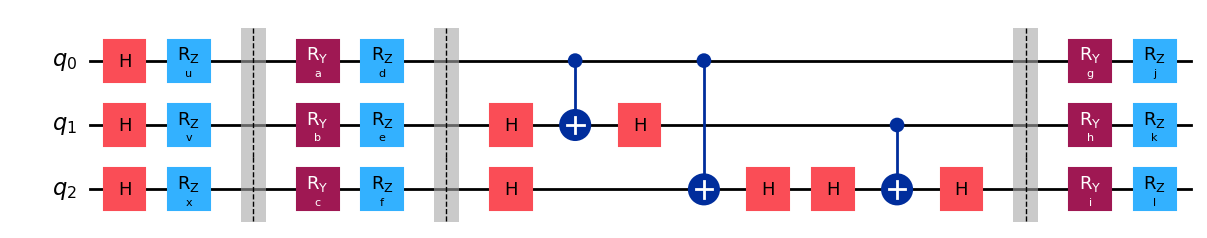

In [80]:
qc = QuantumCircuit(3)
qc = qc.compose(qnn_encoding())
qc= qc.compose(var_circ())
qc.draw("mpl")